In [260]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
from torch.nn import functional as F
from torch.utils.model_zoo import load_url as load_state_dict_from_url
import scipy
import scipy.misc
from scipy import ndimage
import math
import os
import random

In [261]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [262]:
network = Net()

In [263]:
network.load_state_dict(torch.load('mnist.pth'))

<All keys matched successfully>

In [264]:
network

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [265]:

class DeepDream():
    '''
    Given a network, input size to the network and channel wise mean,std of the data it was trained on,
    label specific 'deep dream' images can be created

    '''

    def __init__(self,net,input_size,data_mean=None,data_std=None,use_gaussian_filter=False):
        self.device = None
        self.net = net
        self.input_size = input_size
        self.data_mean = data_mean
        self.data_std = data_std
        self.input_2d = False
        self.input_3d = False
        self.ouputImage = None
        self.use_gaussian_filter = use_gaussian_filter
        # list variables used in randomDream method
        self.labels = [i for i in range(1000)]
        # set methods
        self.setDevice()
        self.setNetwork()
        self.check_input()
        if self.use_gaussian_filter == True:
            print("Gaussian filter will be used")
            self.gaussian_filter = None
            self.setGaussianFilter()

    def setDevice(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device used to run this program: ",self.device)


    def setNetwork(self):
        print("Loading the network...")
        
        self.net.eval() # inference mode

        self.net.to(self.device)
        print("Network Loaded")
        
    def check_input(self):
        assert len(self.input_size) == 3
        if self.input_size[0] == 1: self.input_2d = True
        else: self.input_3d = True
        if self.input_2d:   
            if self.data_mean is None: 
                self.data_mean = 0.5
                print("Data means set at 0.5 by default")
            if self.data_std is None: 
                self.data_std = 0.5
                print("Data standard deviation set at 0.5 by default")


    def __call__(self,im=None,label=0,nItr=100,lr=0.1):
        """Does activation maximization on a specific label for specified iterations,
           acts like a functor, and returns an image tensor
        """

        if im is None:
            im = self.createInputImage()
            im = self.prepInputImage(im)
            im = im.to(self.device)

            im = Variable(im.unsqueeze(0),requires_grad=True)

        softmaxed_activation = F.softmax(self.net(im),dim=1)
        val,index = softmaxed_activation.max(1)
        print("Probablity before optimizing : {} and label {}".format(val[0],index[0]))
        print("Dreaming...")

        for i in range(nItr):

            out = self.net(im)
            #loss = -out[0,label]
            loss = out[0,label]
            loss.backward()

            avg_grad = np.abs(im.grad.data.cpu().numpy()).mean()
            norm_lr = lr / (avg_grad + 1e-20)
            im.data += norm_lr * im.grad.data
            im.data = torch.clamp(im.data,-1,1)
            
            if self.use_gaussian_filter == True:
                im.data = self.gaussian_filter(im.data)

            im.grad.data.zero_()
        
        softmaxed_activation = F.softmax(self.net(im),dim=1)
        val,index = softmaxed_activation.max(1)
        print("Probablity after optimizing : {} and label {}".format(val[0],index[0]))

        return im

    def randomDream(self,im=None,randomSeed=0):
        """Does activation maximization on a random label for randomly chosen learning rate,number of iterations and gaussian filter size, and returns an image tensor
        """
        random.seed(randomSeed)
        rand_nItr = np.asscalar(np.random.normal(500,40,1).astype(int))
        rand_lr = np.asscalar(np.random.normal(0.12,0.01,1))
        rand_label = random.choice(self.labels)
        if self.use_gaussian_filter == True:
            rand_sigma = np.asscalar(np.random.normal(0.45,0.05,1))
            self.setGaussianFilter(sigma=rand_sigma)

        im = self.__call__(im,label=rand_label,nItr=rand_nItr,lr=rand_lr)

        return im


    def createInputImage(self):
        if self.input_2d:
            input_size = (self.input_size[1],self.input_size[2])
            zeroImage_np = np.ones(input_size)*127
            zeroImage = Image.fromarray((zeroImage_np).astype('uint8'),'L')

        return zeroImage

    def prepInputImage(self,inputImage):
        if self.input_2d:
            if (self.data_mean is not None) and (self.data_std is not None):
                preprocess = transforms.Compose([
                transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Normalize(self.data_mean,self.data_std),
                ])

        return preprocess(inputImage)

    def postProcess(self,image):
        image_tensor = torch.squeeze(image.data) # remove the batch dimension
        if self.input_2d:
    #        image_tensor.transpose_(0,1) # convert from CxHxW to HxWxC format
    #        image_tensor.transpose_(1,2)
            image_tensor = image_tensor*self.data_std[0] + self.data_mean[0] # std and mean for mjsynth 

            image_tensor = image_tensor.cpu() # back to host

            img = Image.fromarray((image_tensor.data.numpy()*255).astype('uint8'), 'L') #torch tensor to PIL image_tensor

        return img

    def show(self,img):
#         plt.figure(num=1, figsize=(12, 8), dpi=120, facecolor='w', edgecolor='k')
        plt.imshow(img,'gray')

    def save(self,image,fileName):
        #image = image.resize((32,256), Image.ANTIALIAS)
        image.save(fileName,'PNG')
        print('{} saved'.format(fileName))

    def setGaussianFilter(self,kernelSize=3,sigma=0.5):
        if self.input_2d:
            # Create a x, y coordinate grid of shape (kernelSize, kernelSize, 2)
            x_cord = torch.arange(kernelSize)
            x_grid = x_cord.repeat(kernelSize).view(kernelSize, kernelSize)
            y_grid = x_grid.t()
            xy_grid = torch.stack([x_grid, y_grid], dim=-1)
            xy_grid = xy_grid.float()

            mean = (kernelSize - 1)/2.
            variance = sigma**2.


            # Calculate the 2-dimensional gaussian kernel which is
            # the product of two gaussian distributions for two different
            # variables (in this case called x and y)
            gaussian_kernel = (1./(2.*math.pi*variance)) * torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) /(2*variance))
            # Make sure sum of values in gaussian kernel equals 1.
            gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

            # Reshape to 2d depthwise convolutional weight
            gaussian_kernel = gaussian_kernel.view(1, 1, kernelSize, kernelSize)
#             gaussian_kernel = gaussian_kernel.repeat(3, 1, 1, 1)

            pad = math.floor(kernelSize/2)

            gauss_filter = nn.Conv2d(in_channels=1, out_channels=1,padding=pad,
                                kernel_size=kernelSize, groups=1, bias=False)

            gauss_filter.weight.data = gaussian_kernel
            gauss_filter.weight.requires_grad = False
            self.gaussian_filter = gauss_filter.to(self.device)
            #print("gaussian_filter created")


In [266]:
dreamer = DeepDream(network,(1,28,28),(0.13,),(0.31,),use_gaussian_filter=True)

Device used to run this program:  cpu
Loading the network...
Network Loaded
Gaussian filter will be used


In [275]:
dreamer.data_mean[0]

0.13

In [276]:
dream = dreamer(label=9,nItr=500)

/home/elias/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Probablity before optimizing : 0.13195645809173584 and label 8
Dreaming...
Probablity after optimizing : 0.9916484355926514 and label 9


In [277]:
output = dreamer.postProcess(dream)

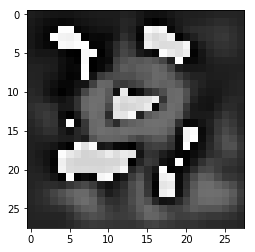

In [278]:
dreamer.show(output)